In [193]:
#!XL
import tensorflow as tf
from pathlib import Path
import cv2
import pandas as pd
from PIL import Image
from io import BytesIO
import requests

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
from IPython import display
from tqdm import tqdm_notebook as tqdm
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import UpSampling2D, Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Reshape, Flatten

from tqdm.notebook import tqdm
from ipywidgets import IntProgress
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
init = RandomNormal(mean=0.0, stddev=0.02)

Using TensorFlow backend.


In [327]:
#!XL
class DCGAN(tf.keras.Model):

    def __init__(self, image_size, output_path, num_channels=1, z_dim=128,
                 G_h_size=128, D_h_size=128, batch_size=256):
        super().__init__()
        self.image_size = image_size
        self.num_channels = num_channels
        self.z_dim = z_dim

        self.output_path = output_path

        self.G_h_size = G_h_size
        self.D_h_size = D_h_size

        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()

        self.optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5, beta_2=0.900)

        self.batch_size = batch_size
        self._vis_h = 5
        self._vis_w = 5
        self._vis_noise = np.random.normal(0, 1, (self._vis_h* self._vis_w, self.z_dim)).astype(np.float32)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)
    
    def _conv_bn_leaky(self, kernel_size, channels, stride=1):
        """
        Этот блок мы будем часто использовать -- поэтому вынесем его в отдельную функцию

        Он содержит Conv + BatchNorm + LeakyReLU

        При указании stride=2 -- уменьшит размер в два раза.
        """
        model = tf.keras.Sequential()
        model.add(Conv2D(channels,
                         kernel_size=kernel_size, padding="same",
                         use_bias=False, kernel_initializer=init,
                         strides=(stride, stride))) # use_bias=False, т.к. BatchNorm и так вычтет среднее
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        return model
        

    def _build_generator(self):
        """
        Генератор должен превращать вектор длины self.z_dim в 
        картинку 32x32x1

        """
        model = tf.keras.Sequential()
        # для начала сделаем вектор -- трехмерным тензором м помощью Reshape
        model.add(Reshape((1, 1, self.z_dim), input_shape=(self.z_dim,)))

        # Превратим его в тензор размера (4, 4, self.G_h_size * 4)
        model.add(Conv2DTranspose(self.G_h_size * 4, kernel_size=4, use_bias=False, kernel_initializer=init))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        upsamples_num = int(np.log2(self.image_size / 8)) # столько раз применим апсемплинг в цикле, 
                                                          # чтобы из (4,4) получить (image_size/2, image_size/2)
                                                          # в нашем случае -- 2 (image_size=32)
        
        for i in range(upsamples_num):
            model.add(UpSampling2D()) # увеличиваем картинку
            model.add(self._conv_bn_leaky(4, self.G_h_size * 4 // 2**(i+1))) # уменьшаем количество фильтров в два раза
            
        model.add(UpSampling2D())
        model.add(Conv2D(self.num_channels,
                         kernel_size=4, strides=(1, 1),
                         activation="tanh", padding="same", 
                         kernel_initializer=init))
        return model

    def _build_discriminator(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.InputLayer(
            input_shape=((self.image_size, self.image_size, self.num_channels))))
        model.add(self._conv_bn_leaky(kernel_size=4, 
                                      channels=self.D_h_size,
                                      stride=2,
                                      ))
        
        downsamples_num = int(np.log2(self.image_size / 8)) # столько раз применим доунсэмплинг в цикле, 
                                                          # чтобы из (image_size/2, image_size/2) получить (4,4) 
        for i in range(downsamples_num):
            model.add(self._conv_bn_leaky(kernel_size=4, 
                                          channels=self.D_h_size * (2 ** (i+1)),
                                          stride=2)) # количество фильтров увеличивается, размер уменьшается
        
        # после цикла получили тензор размера (4, 4, 256), значит свернув его с ядром (4,4,256,1) -- получим число
        model.add(Conv2D(1, kernel_size=4, kernel_initializer=init)) # без активации !
        model.add(Flatten())
        return model
    
    @tf.function
    def train_step(self, images):
        """
        Шаг обучения как в прошлом уроке
        """
        noise = tf.random.normal([tf.cast(images.shape[0], tf.int32), self.z_dim])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)
            
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

    def save_imgs(self, epoch):
        """
        Сохранение промежуточных картинок на диск
        """
        gen_imgs = self.generator(self._vis_noise, training=False)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(self._vis_h, self._vis_w, figsize=(6,6))
        cnt = 0
        for i in range(self._vis_h):
            for j in range(self._vis_w):
                if self.num_channels == 1:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                else:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(self.output_path / f"mnist_{epoch}.png")
        plt.show()
    
    def train(self, dataset, epochs):
        """
        Цикл обучения
        """
        for epoch in tqdm(range(epochs)):
            start = time.time()
            iters = 0
            for image_batch in dataset:
                self.train_step(image_batch)
                iters += 1
                if iters % 100 == 0:
                    display.clear_output(wait=True)
                    self.save_imgs(f"{epoch}:{iters}")
            
            display.clear_output(wait=True)
            self.save_imgs(epoch)
            
            print(f'Time for epoch {epoch} is {time.time() - start} sec')

In [328]:
#!XL
output = Path("proba")
output.mkdir(exist_ok=True)
BATCH_SIZE = 64
IMAGE_SIZE = 64
EPOCHS = 1000
gan = DCGAN(image_size=IMAGE_SIZE, num_channels=1, output_path=output, z_dim=64, D_h_size=64, G_h_size=64)

In [329]:
#!XL
gan.generator.summary()

Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 1, 1, 64)          0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 4, 4, 256)         262144    
_________________________________________________________________
batch_normalization_74 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_74 (LeakyReLU)   (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d_37 (UpSampling (None, 8, 8, 256)         0         
_________________________________________________________________
sequential_84 (Sequential)   (None, 8, 8, 128)         524800    
_________________________________________________________________
up_sampling2d_38 (UpSampling (None, 16, 16, 128)     

In [330]:
#!XL
gan.discriminator.summary()

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_88 (Sequential)   (None, 32, 32, 64)        1280      
_________________________________________________________________
sequential_89 (Sequential)   (None, 16, 16, 128)       131584    
_________________________________________________________________
sequential_90 (Sequential)   (None, 8, 8, 256)         525312    
_________________________________________________________________
sequential_91 (Sequential)   (None, 4, 4, 512)         2099200   
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 1, 1, 1)           8193      
_________________________________________________________________
flatten_9 (Flatten)          (None, 1)                 0         
Total params: 2,765,569
Trainable params: 2,763,649
Non-trainable params: 1,920
_______________________________________

In [331]:
#!XL
def generate_data(latent_vector, generator):
    """
    Для того чтобы сгенерировать объект нам нужен генератор и латентный вектор
    """
    gen_imgs = generator(latent_vector, training=False)
    gen_imgs = 0.5 * gen_imgs + 0.5
    return gen_imgs

Вектор:  [ 1.4864793  -0.7209226   1.3047832   0.13696128  0.6602987   0.9178467
  0.5986762   0.8128637   1.6533753  -0.24849725]


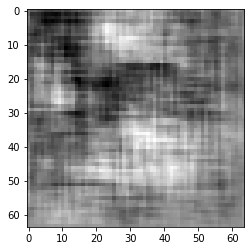

In [332]:
#!XL
v1 = tf.random.normal([1, 64]) # случайный вектор
print("Вектор: ", v1.numpy()[0, :10]) # распечатаем 10 первых элементов
_ = plt.imshow(generate_data(v1, gan.generator)[0, ..., 0], cmap="gray") # ган не обучен -- получим что-то непонятное

In [49]:
#!XL
URL = 'https://api.ratengoods.com/api/v0.10/image/'
data = pd.read_csv('data.csv')
data.key = data.key.astype(str)
data['links'] = URL + data.key
data.drop(columns=['Unnamed: 0'], inplace=True)
data = data.drop_duplicates(subset=['key'])
data.prod_id = data.prod_id.astype(int)
data

,key,name,source,prod_id,free_use,links
0,8732978,e214c0de5ab3134d7a8f918155af56826fe2872f.jpeg,USER,9489403,True,https://api.ratengoods.com/api/v0.10/image/873...
1,8722550,f010addceda8b3f61c2058023cba3aa3e4ff9842.jpeg,USER,2015371,True,https://api.ratengoods.com/api/v0.10/image/872...
2,8746670,0d378faeca33719cc5d2590a8ae0c018cd509885.jpeg,USER,8241001,True,https://api.ratengoods.com/api/v0.10/image/874...
3,8659332,a73d8495b5ccf2ce690690c3efad6739a8810b06.jpeg,USER,633711,True,https://api.ratengoods.com/api/v0.10/image/865...
4,8920811,36fa2a9a9dab9568ffc8de3a7c255ec0a6e8b28f.jpeg,USER,6633365,True,https://api.ratengoods.com/api/v0.10/image/892...
...,...,...,...,...,...,...
11971580,29641742,fe4c778094767ada41f9f0e030c72d4b08a7d6f5.jpeg,USER,30290197,True,https://api.ratengoods.com/api/v0.10/image/296...
11971592,342408,9b253544ef20fb4a18bc46861a74f001f21cb8e5.jpeg,USER,634376,True,https://api.ratengoods.com/api/v0.10/image/342408
11971594,403652,e4e9fde6e3005bd6daa9290389ce26cce1117d41.jpeg,USER,5959617,True,https://api.ratengoods.com/api/v0.10/image/403652
11971625,29641752,7075b4f9324e0f3521098958a8cdeef4bb70fe7e.jpeg,USER,29229119,True,https://api.ratengoods.com/api/v0.10/image/296...


In [51]:
#!XL
prod_ids = data.groupby(['prod_id']).size().reset_index(name='counts').sort_values(['counts'], ascending=False).prod_id.values[2:22]
prod_ids

array([2035578, 6092452,  885418, 6306467, 8103913, 8100001, 6420176,
       5783910,  240014, 8393179,  240099,  236751,  678969, 3155608,
       2340987,  511517, 2863813, 8575738, 2494432,  685331])

In [52]:
#!XL
data['kek'] = data.prod_id.apply(lambda x: x in prod_ids)
top20 = data[data.kek == True]
top20 = top20.reset_index().drop(columns=['index', 'kek'])
top20

,key,name,source,prod_id,free_use,links
0,8752976,90160a427196556ae074d85335bc40ce7710567a.jpeg,USER,3155608,True,https://api.ratengoods.com/api/v0.10/image/875...
1,8666831,a4595bc0bfd626e356a40287aad239dc1d3b2027.jpeg,USER,6092452,True,https://api.ratengoods.com/api/v0.10/image/866...
2,2609661,0bc53ca0482f1d17eaf2d67ca97eff25ef0a7755.jpeg,RNG,8103913,False,https://api.ratengoods.com/api/v0.10/image/260...
3,2609662,4fea65bfa661691b13fe265c6ede8f43d47118e0.jpeg,RNG,8103913,False,https://api.ratengoods.com/api/v0.10/image/260...
4,2609663,5b3698dbaf7bc8b3e3e569fc5709fe79f7841c9f.jpeg,RNG,8103913,False,https://api.ratengoods.com/api/v0.10/image/260...
...,...,...,...,...,...,...
2607,29464798,263510b0bc49cfa0dc19d8c362d1ee94af9890c0.jpeg,admitad_utkonos,6306467,False,https://api.ratengoods.com/api/v0.10/image/294...
2608,29500502,b0aa2e292afcc5c3fd0dd50f96a77f9fc7db37a2.jpeg,USER,2340987,True,https://api.ratengoods.com/api/v0.10/image/295...
2609,29639414,bcbece4c3807c06b4241a8cf77de3ab2b37f97d1.jpeg,USER,6092452,True,https://api.ratengoods.com/api/v0.10/image/296...
2610,29639406,8462d6a63d39daa727db26ff5cdf25b46743a139.jpeg,USER,6092452,True,https://api.ratengoods.com/api/v0.10/image/296...


In [53]:
#!XL
dat = top20[(top20.prod_id == 6092452) | (top20.prod_id == 6306467)]
dat

,key,name,source,prod_id,free_use,links
1,8666831,a4595bc0bfd626e356a40287aad239dc1d3b2027.jpeg,USER,6092452,True,https://api.ratengoods.com/api/v0.10/image/866...
7,8759051,7ab290bd821ceee0038824ac50be34dd5389cb5c.jpeg,USER,6092452,True,https://api.ratengoods.com/api/v0.10/image/875...
40,8684554,5687e16b3c4aed26eb87ee69698035c9e367817d.jpeg,USER,6092452,True,https://api.ratengoods.com/api/v0.10/image/868...
56,8684906,2545f6379b8584c4e985ebe2bccd122f3faca818.jpeg,USER,6092452,True,https://api.ratengoods.com/api/v0.10/image/868...
58,8286082,f7bc77ce1b4731f404003b3eea44b461784f263f.jpeg,USER,6092452,True,https://api.ratengoods.com/api/v0.10/image/828...
...,...,...,...,...,...,...
2599,29145786,73d75b7e963b8f6727f87259efc489c56b6a487e.jpeg,admitad_utkonos,6306467,False,https://api.ratengoods.com/api/v0.10/image/291...
2607,29464798,263510b0bc49cfa0dc19d8c362d1ee94af9890c0.jpeg,admitad_utkonos,6306467,False,https://api.ratengoods.com/api/v0.10/image/294...
2609,29639414,bcbece4c3807c06b4241a8cf77de3ab2b37f97d1.jpeg,USER,6092452,True,https://api.ratengoods.com/api/v0.10/image/296...
2610,29639406,8462d6a63d39daa727db26ff5cdf25b46743a139.jpeg,USER,6092452,True,https://api.ratengoods.com/api/v0.10/image/296...


In [54]:
#!XL
from sklearn.model_selection import train_test_split

In [55]:
#!XL
links_train, links_test = train_test_split(dat.links.values, test_size=0.2, random_state=100)

In [302]:
#!XL
def crop(link):
    
    im = Image.open(BytesIO(requests.get(link).content)).resize((64,64)).convert('L')
    im = np.array(im)
            
    return im

In [303]:
#!XL
X = []
Y = []

for x in tqdm(dat.links.values):
    try:
        X.append(crop(x))
        Y.append(dat[dat.links == x].prod_id)
    except:
        continue
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

100%|██████████| 294/294 [01:05<00:00,  4.50it/s]


((294, 64, 64), (294, 1))

In [304]:
#!XL
X.shape, Y.shape

((294, 64, 64), (294, 1))

In [305]:
#!XL
classes = dict(zip(np.unique(Y), list(range(20))))
classes

{6092452: 0, 6306467: 1}

In [306]:
#!XL
y = [classes[int(x)] for x in Y]
y = np.array(y)

In [333]:
#!XL
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [334]:
#!XL
# Подготовим данные. 
# 1. Увеличим картинки до 32x32 -- в целях более удобного деления на 2
# 2. Преобразуем яркости из 0..255 в -1..1
# 3. Используя функции tensorflow превратим датасет в итератор по батчам. (раньше за нас это делал Keras)

X_train = X_train.reshape(X_train.shape[0], 64, 64, 1).astype('float32')
X_train = tf.image.resize(X_train, (64, 64), tf.image.ResizeMethod.NEAREST_NEIGHBOR)

X_train = (X_train - 127.5) / 127.5 
train_dataset = tf.data.Dataset.from_tensor_slices(X_train)

In [335]:
#!XL
# создав датасет таким образом, мы можем теперь итерироваться по нему так
for img in train_dataset.take(4):
    print(img.shape) # но он возвращает только одну картинку за раз

(64, 64, 1)
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)


In [336]:
#!XL
# разобьем его на батчи и перемешаем (BUFFER_SIZE -- параметр перемешивания, обычно равен размеру датасета)
BUFFER_SIZE = 294

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
for img in train_dataset.take(4):
    print(img.shape) # теперь итерирование происходит по батчам

(64, 64, 64, 1)
(64, 64, 64, 1)
(64, 64, 64, 1)
(43, 64, 64, 1)


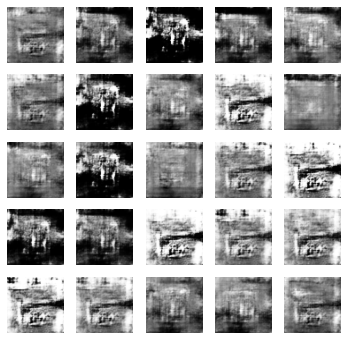

100%|██████████| 1000/1000 [17:02<00:00,  1.02s/it]

Time for epoch 999 is 0.9282944202423096 sec


In [337]:
#!XL
gan.train(train_dataset, EPOCHS)

Вектор:  [ 0.11191469  0.5217864  -0.3804061   0.88678616 -1.4120497  -0.7479163
  0.18206239 -0.53402436 -1.9550021   2.0188646 ]


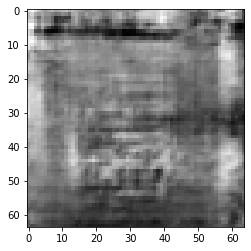

In [342]:
#!XL
v1 = tf.random.normal([1, 64]) # случайный вектор
print("Вектор: ", v1.numpy()[0, :10]) # распечатаем 10 первых элементов
_ = plt.imshow(generate_data(v1, gan.generator)[0, ..., 0], cmap="gray")

In [ ]:
#!XL


In [ ]:
#!XL


In [ ]:
#!XL


In [ ]:
#!XL


In [ ]:
#!XL


In [ ]:
#!XL


In [ ]:
#!XL


In [ ]:
#!XL


In [ ]:
#!XL


In [141]:
#!XL
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Activation, Concatenate
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tqdm.notebook import tqdm

from IPython.display import Image
import matplotlib.pyplot as plt
import os

In [142]:
DEPTH = 10
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = train_images / 255 # нормализуем в [0, 1]
train_labels = np.array(to_categorical(train_labels, DEPTH))

11493376/11490434 [==============================] - 0s 0us/step


In [158]:
#!XL
RANDOM_DIM = 100

class DataGenerator():
    def __init__(self, train_images, train_labels, batches_per_epoch, batch_size):
        self.train_images = train_images
        self.train_labels = train_labels
        self.batches_per_epoch = batches_per_epoch
        self.batch_size = batch_size
    
    @staticmethod
    def rand_norm(npoints=1, ndim=RANDOM_DIM):
        rand_vec = np.random.normal(0, 1, size=[npoints, ndim])
        # проекция на поверхность сферы
        # rand_vec = rand_vec / np.sqrt(np.sum(np.square(rand_vec), axis=1))[:, np.newaxis]
        return rand_vec

    def __len__(self):
        return self.batches_per_epoch
    
    def batch(self):
        rand_images_indexes = np.random.randint(0, train_images.shape[0], size=self.batch_size)
        image_batch = train_images[rand_images_indexes]
        labels_batch = train_labels[rand_images_indexes]
        return image_batch, labels_batch
    
    def __iter__(self):
        for b in tqdm(range(self.batches_per_epoch), leave=False):
            yield self.batch()
            
    def rand_batch(self):
        rand_vec = self.rand_norm(self.batch_size)
        rand_labels = np.random.randint(0, 10, size=[self.batch_size])
        rand_labels = np.array(to_categorical(rand_labels, DEPTH))
        return [rand_vec, rand_labels]

np.random.seed(42)
images_indexes = np.random.randint(0, len(train_images), size=16)
PICS_FROM_DATASET = [train_images[images_indexes], train_labels[images_indexes]]
FIXED_NOISE = [DataGenerator.rand_norm(16), train_labels[images_indexes]]

In [159]:
#!XL
def make_generator():
    complexity = 80
    alpha = 0.2
    
    random_vector = Input(shape=[RANDOM_DIM])
    labels = Input(shape=[DEPTH])
    
    X = Concatenate()([random_vector, labels])
    # 1 слой
    X = Dense(7 * 7 * int(complexity/2),
                          input_dim=RANDOM_DIM,
                          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02))(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha)(X)
    
    X = Reshape((7, 7, int(complexity/2)))(X)
    
    # 2 слой
    X = Conv2DTranspose(int(complexity), 
                        kernel_size=(5, 5),
                        strides=(2, 2),
                        padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha)(X)

    # 3 слой
    X = Conv2DTranspose(int(complexity),
                        kernel_size=(5, 5),
                        strides=(1, 1),
                        padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha)(X)
    
    # 4 слой
    X = Conv2DTranspose(int(complexity),
                        kernel_size=(5, 5),
                        strides=(1, 1),
                        padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha)(X)
    
    # 5 слой
    X = Conv2DTranspose(int(complexity),
                        kernel_size=(5, 5),
                        strides=(1, 1),
                        padding='same')(X)
    X = BatchNormalization()(X)
    X = LeakyReLU(alpha)(X)
    
    # 6 слой
    X = Conv2DTranspose(1,
                        kernel_size=(5, 5),
                        strides=(2, 2),
                        padding='same')(X)
    X = Activation('sigmoid')(X)
    
    model = Model(inputs=[random_vector, labels], outputs=X, name='generator')
    model.compile(loss='binary_crossentropy',
                  metrics=['acc'],
                  optimizer='sgd')
    model.summary()
    return model
generator = make_generator()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 110)          0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1960)         217560      concatenate[0][0]        

/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 59
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'tuple'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:818: UserWarning: The following variables cannot be serialized: discriminator, generator
  warnings.warn(message)


Folder already exists


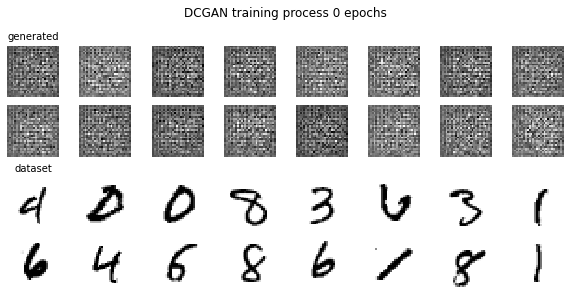

/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'str'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:818: UserWarning: The following variables cannot be serialized: discriminator, generator
  warnings.warn(message)


In [160]:
#!XL
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError:
        print('Folder already exists')

def plot_and_save_images(generated_images, folder_name, title, cols, rows, figsize, show=False, subtitles=False):
    fig, axs = plt.subplots(rows, cols, constrained_layout=True)
    fig.set_figheight(figsize[0])
    fig.set_figwidth(figsize[1])
    for i in range(rows):
        for j in range(cols):
            axs[i][j].imshow(generated_images[i][j], interpolation='nearest', cmap='gray_r')
            axs[i][j].axis('off')
            if not subtitles is None:
                if i == 0 and j == 0:
                    axs[i][j].set_title(subtitles[0], fontsize=10)
                if i == int(rows/2) and j == 0:
                    axs[i][j].set_title(subtitles[1], fontsize=10)
    
    fig.suptitle(title, fontsize=12)
    plt.savefig(os.path.join(folder_name, title + '.png'))
    if show:
        plt.show()
    plt.close()


def plot_generated_images(noise, folder_name, title, cols=8, rows=4, figsize=(4, 8), show=False, subtitles=('generated', 'dataset')):
    generated_images = generator.predict(noise)
    images = np.concatenate([generated_images, PICS_FROM_DATASET[0]])
    images = images.reshape(rows, cols, 28, 28)
    plot_and_save_images(images, folder_name, title, cols, rows, figsize, show, subtitles)
    

folder_name = 'GAN_pics_for_gif'
mkdir_p(os.path.join(folder_name))

title = f"DCGAN training process {0} epochs"
plot_generated_images(FIXED_NOISE, folder_name, title, show=True)

In [176]:
#!XL
def optimizer():
    return tf.keras.optimizers.Adam(lr=0.0008, beta_1=0.3)

/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 11
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 11
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 11
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'NoneType'>
Walking trough too many objects
Use %enable_full_walk

In [177]:
#!XL
def make_discriminator():
    complexity = 70
    drop_rate = 0.2
    alpha = 0.2
    
    inp = Input(shape=(28, 28, 1))
    X = inp
    # 1 слой
    X = Conv2D(int(complexity/4),
               kernel_size=(5, 5),
               strides=(2, 2),
               kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
               padding='same')(X)
    X = LeakyReLU(alpha)(X)
    X = Dropout(drop_rate)(X)
    
    # 2 слой
    X = Conv2D(int(complexity/2),
               kernel_size=(5, 5),
               strides=(2, 2),
               #kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
               padding='same')(X)
    X = LeakyReLU(alpha)(X)
    X = Dropout(drop_rate)(X)
    
    # 3 слой
    X = Conv2D(int(complexity),
               kernel_size=(5, 5),
               strides=(2, 2),
               #kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
               padding='same')(X)
    X = LeakyReLU(alpha)(X)
    X = Dropout(drop_rate)(X)
    
    # 4 слой
    X = Conv2D(int(2*complexity),
               kernel_size=(5, 5),
               strides=(1, 1),
               #kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
            padding='same')(X)
    X = LeakyReLU(alpha)(X)
    X = Dropout(drop_rate)(X)
    
    # 5 слой
    X = Conv2D(int(complexity),
               kernel_size=(5, 5),
               strides=(1, 1),
               #kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
               padding='same')(X)
    X = LeakyReLU(alpha)(X)
    X = Dropout(drop_rate)(X)

    # 6 слой
    X = Flatten()(X)
    X_real_fake = Dense(1, activation='sigmoid', name='real_fake')(X)
    # 6 слой
    X_labels = Dense(DEPTH, activation='softmax', name='labels')(X)
    
    model = Model(inputs=inp, outputs=[X_real_fake, X_labels], name='discriminator')
    model.compile(loss={'real_fake': 'binary_crossentropy',
                        'labels': 'categorical_crossentropy'},
                  loss_weights={'real_fake':1,
                                'labels': 1},
                  optimizer=optimizer(),
                  metrics={'real_fake':'acc'})
    
    model.summary()
    return model
discriminator = make_discriminator()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 14, 14, 17)   442         input_6[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_20 (LeakyReLU)      (None, 14, 14, 17)   0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 14, 14, 17)   0           leaky_re_lu_20[0][0]             
______________________________________________________________________________________

/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 11
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 11
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 11
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'NoneType'>
Walking trough too many objects
Use %enable_full_walk

In [ ]:
#!XL
discriminator.predict(generator.predict(FIXED_NOISE))

In [178]:
#!XL
def make_gan(discriminator, generator):   
    noise = generator.inputs
    image = generator(noise)
    real_vs_fake_and_label = discriminator(image)
    gan = Model(inputs=noise, outputs=real_vs_fake_and_label)
    # надо выключить обучаемость дискриминатора перед компиляцией
    # т.к. обучением GAN является обучение генератора
    discriminator.trainable = False  
    gan.compile(loss={'discriminator':'binary_crossentropy',
                      'discriminator_1':'categorical_crossentropy'},
                
                optimizer=optimizer(),
                metrics={'discriminator':'acc'})
    discriminator.trainable = True
    gan.summary()
    return gan
gan = make_gan(discriminator, generator)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
generator (Functional)          (None, 28, 28, 1)    789001      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
discriminator (Functional)      [(None, 1), (None, 1 579213      generator[2][0]       

/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 11
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 11
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'tensorflow.python.keras.engine.node.Node'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> wit

In [ ]:
#!XL
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

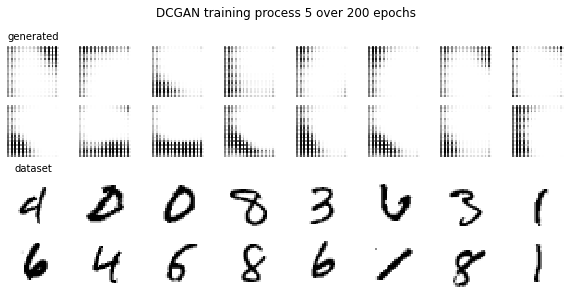

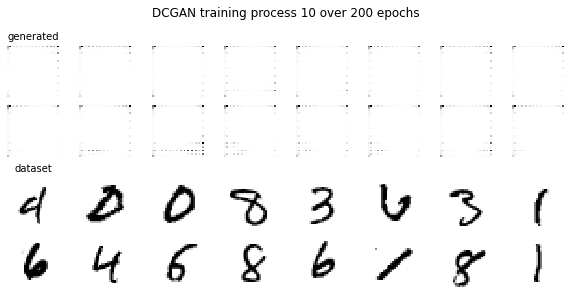

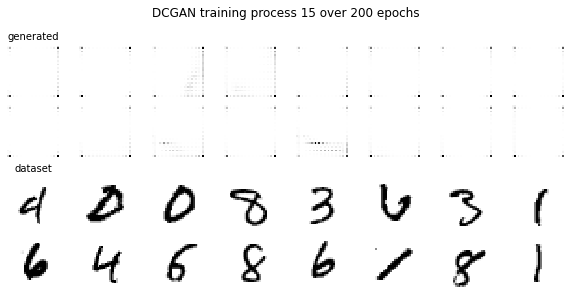

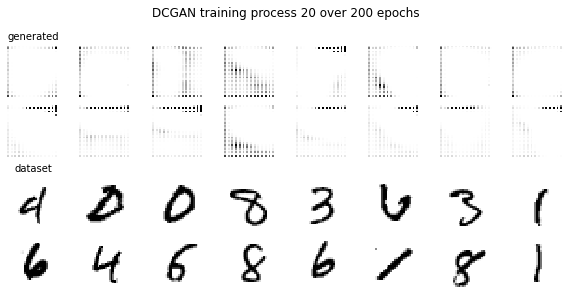

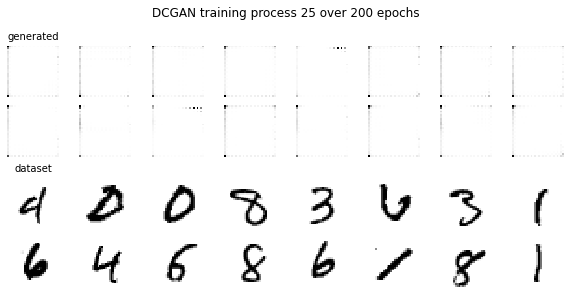

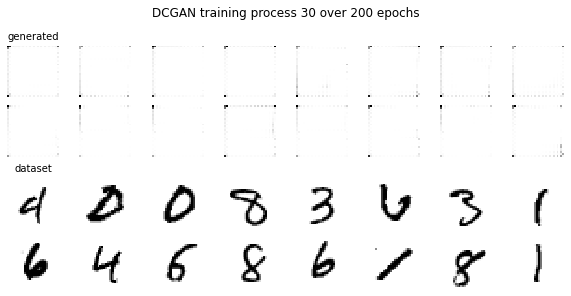

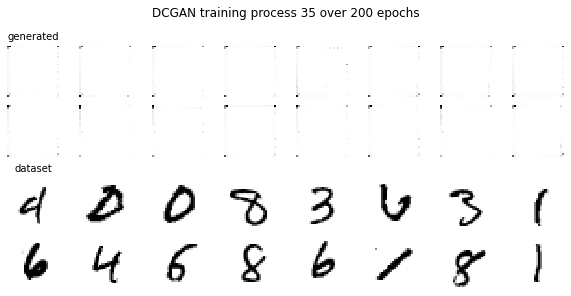

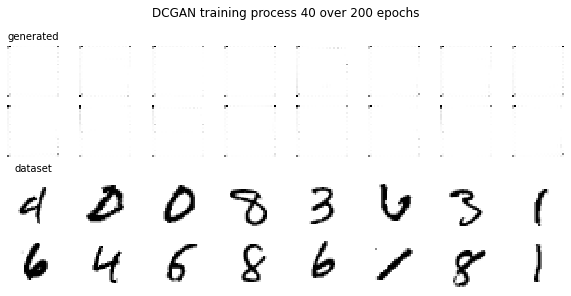

если генератор и дискриминатор сбалансированы, то точность генератора не будет уходить в 0 или 1:
0.45375
если генератор и дискриминатор сбалансированы, то точность генератора не будет уходить в 0 или 1:
0.5814453125
если генератор и дискриминатор сбалансированы, то точность генератора не будет уходить в 0 или 1:
0.514921875
если генератор и дискриминатор сбалансированы, то точность генератора не будет уходить в 0 или 1:
0.4813671875
если генератор и дискриминатор сбалансированы, то точность генератора не будет уходить в 0 или 1:
0.5344140625
если генератор и дискриминатор сбалансированы, то точность генератора не будет уходить в 0 или 1:
0.5279296875
если генератор и дискриминатор сбалансированы, то точность генератора не будет уходить в 0 или 1:
0.5187890625
если генератор и дискриминатор сбалансированы, то точность генератора не будет уходить в 0 или 1:
0.5091796875

Error in callback <function flush_figures at 0x7ff0fbb4f4d0> (for post_execute):


/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 11
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 11
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'tensorflow.python.keras.engine.node.Node'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> wit

KeyboardInterrupt: 

In [179]:
#!XL
EPOCHS = 200
BATCH_SIZE = 128
data = DataGenerator(train_images, train_labels, batches_per_epoch=40, batch_size=BATCH_SIZE)
#массив нужен для отслеживания стабильности обучения
generator_acc_follow = []
for epoch in tqdm(range(1, EPOCHS+1)):
    for images_batch, labels_batch in data:
        # Обучение дискриминатора
        noise = data.rand_batch()
        generated_images = generator.predict(noise)
        X = np.concatenate([images_batch, generated_images])
        # сглаживание целевых значений
        y_real = np.random.uniform(0.8, 1, size=[BATCH_SIZE])
        y_fake = np.random.uniform(0, 0.2, size=[BATCH_SIZE])
        y_real_fake = np.concatenate([y_real, y_fake])
        # целевые значения меток
        y_labels = np.concatenate([labels_batch, np.zeros((BATCH_SIZE, DEPTH))])
        # обучаем дискриминатор
        discriminator.train_on_batch(X, [y_real_fake, y_labels])
        
        # Обучение генератора
        noise = data.rand_batch()
        # задаём целевые значения
        y_real_fake = np.ones(BATCH_SIZE)
        # обучаем GAN и сохраняем точность в массив
        generator_acc_follow.append(gan.train_on_batch(noise, [y_real_fake, noise[1]])[-1])

    # построим изображение и сохраним его для создания .gif
    title = f"DCGAN training process {epoch} over {EPOCHS} epochs"
    if epoch%int(EPOCHS/40)==0:
        plot_generated_images(FIXED_NOISE, folder_name, title, show=True)
        print('если генератор и дискриминатор сбалансированы, то точность генератора не будет уходить в 0 или 1:')
        print(np.mean(generator_acc_follow))
        generator_acc_follow = []
    else:
        plot_generated_images(FIXED_NOISE, folder_name, title)
        
generator.save('generator_trained.h5')

In [ ]:
#!XL
for folder_data in os.walk(os.path.join(folder_name)):
    all_pics_filenames = sorted(folder_data[2], key=lambda x: int(x.split()[3]))

with imageio.get_writer('DCGAN training.gif', mode='I', fps=60) as writer:
    for filename in tqdm(all_pics_filenames):
        image = imageio.imread(os.path.join(folder_name, filename))
        writer.append_data(image)
        
with open('DCGAN training.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

In [ ]:
#!XL


In [ ]:
#!XL


In [ ]:
#!XL


In [190]:
#!XL

from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

In [191]:
#!XL
class SGAN:
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(
            loss=['binary_crossentropy', 'categorical_crossentropy'],
            loss_weights=[0.5, 0.5],
            optimizer=optimizer,
            metrics=['accuracy']
        )

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        noise = Input(shape=(100,))
        img = self.generator(noise)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid, _ = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model(noise, valid)
        self.combined.compile(loss=['binary_crossentropy'], optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(1, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())

        model.summary()

        img = Input(shape=self.img_shape)

        features = model(img)
        valid = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes+1, activation="softmax")(features)

        return Model(img, [valid, label])

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Class weights:
        # To balance the difference in occurences of digit class labels.
        # 50% of labels that the discriminator trains on are 'fake'.
        # Weight = 1 / frequency
        half_batch = batch_size // 2
        cw1 = {0: 1, 1: 1}
        cw2 = {i: self.num_classes / half_batch for i in range(self.num_classes)}
        cw2[self.num_classes] = 1 / half_batch

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # One-hot encoding of labels
            labels = to_categorical(y_train[idx], num_classes=self.num_classes+1)
            fake_labels = to_categorical(np.full((batch_size, 1), self.num_classes), num_classes=self.num_classes+1)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, labels], class_weight=[cw1, cw2])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels], class_weight=[cw1, cw2])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid, class_weight=[cw1, cw2])

            # Plot the progress
            print ("%d [D loss: %f, acc: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/%s.json" % model_name
            weights_path = "saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "mnist_sgan_generator")
        save(self.discriminator, "mnist_sgan_discriminator")
        save(self.combined, "mnist_sgan_adversarial")

In [192]:
#!XL
sgan = SGAN()
sgan.train(epochs=200, batch_size=32, sample_interval=50)

AttributeError: module 'tensorflow.python.framework.ops' has no attribute '_TensorLike'

In [ ]:
#!XL


In [ ]:
#!XL


In [ ]:
#!XL


In [ ]:
#!XL


In [ ]:
#!XL


In [ ]:
#!XL


In [ ]:
#!XL


In [ ]:
#!XL


In [ ]:
#!XL


In [ ]:
#!XL
